### 代码参考：https://github.com/c-bruce/transformer_noise_removal

In [65]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter  # 一种用于数据平滑处理的函数
from scipy.interpolate import interp1d
import random

# DataSet

In [66]:
def random_delta(size, start_value, min_delta, max_delta, precision=1):
    value_range = max_delta - min_delta
    half_range = value_range / 2
    for _ in range(size):
        delta = random.random() * value_range - half_range
        yield round(start_value, precision)
        start_value += delta

def scale_array(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    
    # Scaling between 0 and 1, then to [-1, 1]
    scaled_arr = 2 * (arr - arr_min) / (arr_max - arr_min) - 1
    return scaled_arr

def generate_clean_signal(length, min_delta=-0.1, max_delta=0.1, precision=100):
    """
    Generate a clean signal with random fluctuations.

    Args:
    length (int): The length of the signal.
    min_delta (float): Minimum change in value.
    max_delta (float): Maximum change in value.
    precision (int): Precision of the values.

    Returns:
    numpy.ndarray: Clean signal.
    """
    signal = scale_array(savgol_filter(list(random_delta(length, 0, min_delta, max_delta, precision)), 20, 3))
    return np.array(signal)


def generate_noise_profile(length, num_points=10, min_level=0.05, max_level=0.2):
    """
    Generate a noise profile with varying levels.
    
    Args:
    length (int): The length of the signal.
    num_points (int): Number of points to use for interpolation.
    min_level (float): Minimum noise level.
    max_level (float): Maximum noise level.
    
    Returns:
    numpy.ndarray: Noise level profile for the entire signal length.
    """
    # Generate random noise levels at specific points
    x = np.linspace(0, length - 1, num_points)
    y = np.random.uniform(min_level, max_level, num_points)
    
    # Interpolate to get noise levels for all points
    f = interp1d(x, y, kind='cubic')
    x_new = np.arange(length)
    noise_profile = f(x_new)
    
    return noise_profile

def add_noise(signal, base_noise_level=0.1, variable_noise_factor=0.5):
    """
    Add random noise with varying levels to the signal.
    
    Args:
    signal (numpy.ndarray): The input signal.
    base_noise_level (float): The base level of noise to add.
    variable_noise_factor (float): Factor to determine the variability of noise (0 to 1).
    
    Returns:
    numpy.ndarray: Noisy signal.
    """
    length = len(signal)
    
    # Generate noise profile
    noise_profile = generate_noise_profile(length, 
                                           min_level=base_noise_level * (1 - variable_noise_factor),
                                           max_level=base_noise_level * (1 + variable_noise_factor))
    
    # Generate noise and scale it according to the profile
    noise = np.random.normal(0, 1, length) * noise_profile
    
    noisy_signal = signal + noise
    return noisy_signal

def scale_to_range(clean_signal, noisy_signal, min_val=-1, max_val=1):
    """
    Scale the clean and noisy signals to a specific range.

    Args:
    clean_signal (numpy.ndarray): Clean signal.
    noisy_signal (numpy.ndarray): Noisy signal.
    min_val (float): Minimum value for scaling.
    max_val (float): Maximum value for scaling.

    Returns:
    numpy.ndarray: Scaled clean signal.
    numpy.ndarray: Scaled noisy signal.
    """
    noisy_signal_min = np.min(noisy_signal)
    noisy_signal_max = np.max(noisy_signal)
    clean_signal_scaled = (max_val - min_val) * (clean_signal - noisy_signal_min) / (noisy_signal_max - noisy_signal_min) + min_val
    noisy_signal_scaled = (max_val - min_val) * (noisy_signal - noisy_signal_min) / (noisy_signal_max - noisy_signal_min) + min_val
    return clean_signal_scaled, noisy_signal_scaled

def generate_dataset(num_samples, sequence_length):
    """
    Generate a dataset of clean and noisy signals.

    Args:
    num_samples (int): Number of samples to generate.
    sequence_length (int): Length of each signal.

    Returns:
    numpy.ndarray: Clean signals.
    numpy.ndarray: Noisy signals.
    """
    clean_signals = []
    noisy_signals = []
    
    for _ in range(num_samples):
        clean_signal = generate_clean_signal(sequence_length, -0.1, 0.1)
        noisy_signal = add_noise(clean_signal, np.random.uniform(0.1, 0.5), np.random.uniform(0.5, 1.0))

        clean_signal_scaled, noisy_signal_scaled = scale_to_range(clean_signal, noisy_signal)

        clean_signals.append(clean_signal_scaled)
        noisy_signals.append(noisy_signal_scaled)
    
    return np.array(clean_signals), np.array(noisy_signals)

In [67]:
# 生成数据集
num_samples = 1000
sequence_length = 4634
clean_signals, noisy_signals = generate_dataset(num_samples, sequence_length)

In [68]:
clean_signals.shape, noisy_signals.shape

((1000, 4634), (1000, 4634))

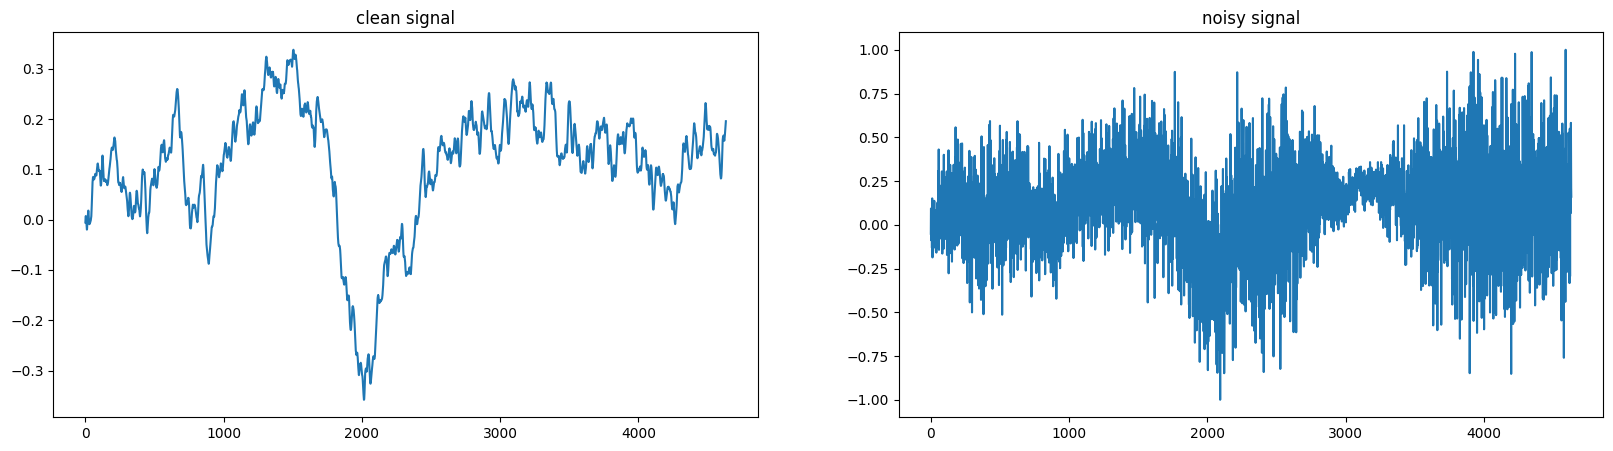

In [69]:
plot_idx = random.randint(0, 1000)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(clean_signals[plot_idx])
plt.title("clean signal")

plt.subplot(1, 2, 2)
plt.plot(noisy_signals[plot_idx])
plt.title("noisy signal")
plt.show()

# Model

In [ ]:
# 位置编码层
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model, n=10000):
        super(PositionalEncoding, self).__init__()
        position = np.arange(seq_len)[:, np.newaxis]
        denominator = np.power(n, 2 * np.arange(0, d_model, 2) / d_model)
        P = np.zeros((seq_len, d_model))
        P[:, 0::2] = np.sin(position / denominator)
        P[:, 1::2] = np.cos(position / denominator)
        self.pos_encoding = torch.tensor(P, dtype=torch.float32).unsqueeze(0)

    def forward(self, inputs):
        self.pos_encoding = self.pos_encoding.to(inputs.device)
        return inputs + self.pos_encoding[:, :inputs.size(1), :]


# 多头注意力机制
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.transpose(1, 2)

    def forward(self, v, k, q, mask=None):
        batch_size = q.size(0)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        matmul_qk = torch.matmul(q, k.transpose(-2, -1))
        dk = torch.tensor(k.size(-1), dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        attention_weights = torch.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.dense(output)

# 前馈网络
class FeedForward(nn.Module):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model),
            nn.Dropout(dropout_rate)
        )
        self.add = nn.Sequential()
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x = self.add([])
        x = self.layer_norm(x + self.seq(x))
        return x

# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        # self.self_attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True)  # 改成调库的版本
        self.ffn = FeedForward(d_model, dff, dropout_rate)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        attn_output = self.self_attention(x, x, x)
        x = x + attn_output
        x = self.ln1(x)
        ffn_output = self.ffn(x)
        x = x + ffn_output
        x = self.ln2(x)
        return x

# 去噪Transformer模型
class NoiseRemovalTransformer(nn.Module):
    def __init__(self, d_model, seq_len, num_heads, dff, num_layers, dropout_rate=0.1):
        super(NoiseRemovalTransformer, self).__init__()
        self.embedding_layer = nn.Linear(1, d_model)
        self.pos_encoding_layer = PositionalEncoding(seq_len, d_model)
        self.enc_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)])
        self.final_layer = nn.Linear(d_model, 1)

    def forward(self, input_x):
        x = self.embedding_layer(input_x)
        x = self.pos_encoding_layer(x)
        for layer in self.enc_layers:
            x = layer(x)
        x = self.final_layer(x)
        return x
        return input_x - x

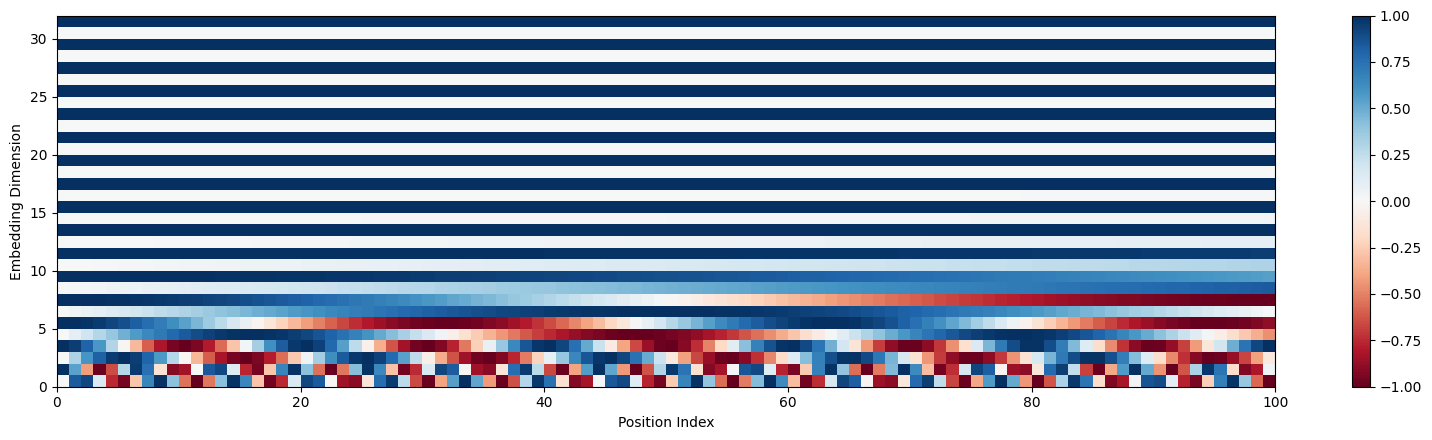

In [71]:
def plot_positional_encoding(pos_encoding, cmap='RdBu'):
    plt.figure(figsize=(16, 4.5))
    plt.pcolormesh(pos_encoding.T, cmap=cmap)
    plt.xlabel('Position Index')
    plt.ylabel('Embedding Dimension')
    plt.clim(-1, 1)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('positional_encoding.png', format='png', dpi=1200)
    plt.show()

# 设置参数
seq_len = 100
d_model = 32

# 实例化 PositionalEncoding 类
positional_encoder = PositionalEncoding(seq_len, d_model)

# 提取位置编码矩阵
positional_encoding_matrix = positional_encoder.pos_encoding.squeeze(0).numpy()

# 调用 plot_positional_encoding 函数绘制位置编码图
plot_positional_encoding(positional_encoding_matrix)

# 训练

In [72]:
# 生成数据集
num_samples = 1000
sequence_length = 4634
clean_signals, noisy_signals = generate_dataset(num_samples, sequence_length)

# 转换为PyTorch张量
clean_signals = torch.tensor(clean_signals, dtype=torch.float32).unsqueeze(-1)
noisy_signals = torch.tensor(noisy_signals, dtype=torch.float32).unsqueeze(-1)
print(f"clean_signals.shape: {clean_signals.shape}, noisy_signals.shape: {noisy_signals.shape}")

# 划分训练集和验证集
train_split = 0.8
split_index = int(num_samples * train_split)
train_clean = clean_signals[:split_index]
train_noisy = noisy_signals[:split_index]
val_clean = clean_signals[split_index:]
val_noisy = noisy_signals[split_index:]

clean_signals.shape: torch.Size([1000, 4634, 1]), noisy_signals.shape: torch.Size([1000, 4634, 1])


Epoch 1/100, Train Loss: 0.1350, Val Loss: 0.0388
Epoch 2/100, Train Loss: 0.0241, Val Loss: 0.0245
Epoch 3/100, Train Loss: 0.0152, Val Loss: 0.0172
Epoch 4/100, Train Loss: 0.0129, Val Loss: 0.0127
Epoch 5/100, Train Loss: 0.0120, Val Loss: 0.0120
Epoch 6/100, Train Loss: 0.0117, Val Loss: 0.0116
Epoch 7/100, Train Loss: 0.0115, Val Loss: 0.0116
Epoch 8/100, Train Loss: 0.0114, Val Loss: 0.0117
Epoch 9/100, Train Loss: 0.0113, Val Loss: 0.0117
Epoch 10/100, Train Loss: 0.0112, Val Loss: 0.0116
Epoch 11/100, Train Loss: 0.0112, Val Loss: 0.0114
Epoch 12/100, Train Loss: 0.0111, Val Loss: 0.0114
Epoch 13/100, Train Loss: 0.0111, Val Loss: 0.0120
Epoch 14/100, Train Loss: 0.0112, Val Loss: 0.0158
Epoch 15/100, Train Loss: 0.0111, Val Loss: 0.0154
Epoch 16/100, Train Loss: 0.0110, Val Loss: 0.0142
Epoch 17/100, Train Loss: 0.0109, Val Loss: 0.0130
Epoch 18/100, Train Loss: 0.0109, Val Loss: 0.0122
Epoch 19/100, Train Loss: 0.0108, Val Loss: 0.0120
Epoch 20/100, Train Loss: 0.0108, Val Lo

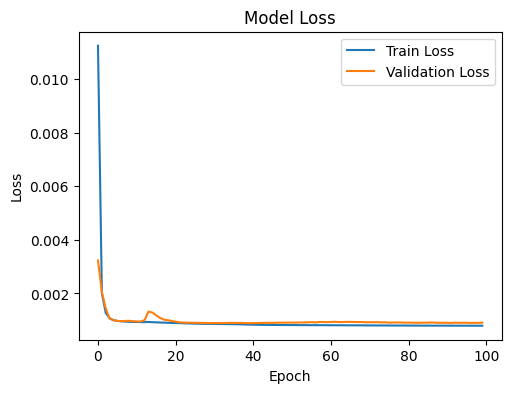

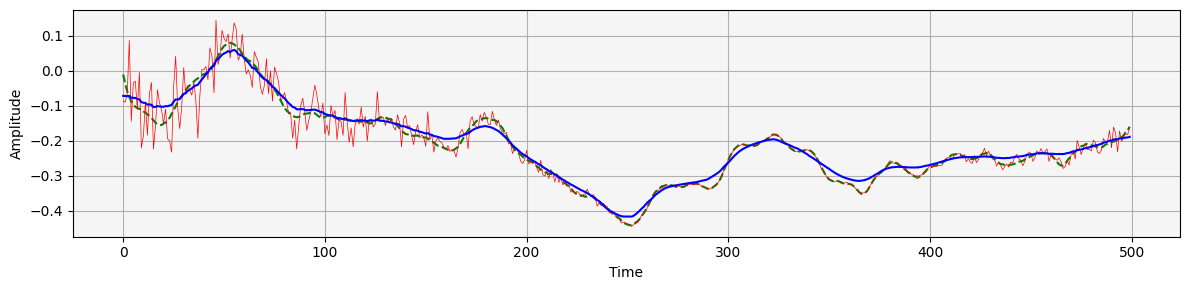

In [79]:
# 定义模型
d_model = 32
num_heads = 1
num_layers = 2
dff = 128
dropout_rate = 0.1

window = 500
window_step = 400

device = torch.device("cuda:1")
model = NoiseRemovalTransformer(
    d_model=d_model, 
    seq_len=sequence_length, 
    num_heads=num_heads, 
    dff=dff, 
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)


train_noisy = train_noisy.to(device)
train_clean = train_clean.to(device)
val_noisy = val_noisy.to(device)
val_clean = val_clean.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练模型
epochs = 100
batch_size = 16
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i in range(0, len(train_noisy), batch_size):
        for j in range(0, 4634, window_step):
            inputs = train_noisy[i:i+batch_size, j:j+window]
            labels = train_clean[i:i+batch_size, j:j+window]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    train_loss = running_loss / (len(train_noisy) // batch_size)
    train_losses.append(train_loss / 12)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(val_noisy), batch_size):
            for j in range(0, 4634, window_step):
                inputs = val_noisy[i:i+batch_size, j:j+window]
                labels = val_clean[i:i+batch_size, j:j+window]
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
    val_loss = val_loss / (len(val_noisy) // batch_size)
    val_losses.append(val_loss / 12)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# 绘制训练历史
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制结果
def plot_results(clean_signal, noisy_signal, denoised_signal):
    plt.figure(figsize=(12, 3))
    plt.plot(clean_signal, color='g', ls='--', label='Clean Signal')
    plt.plot(noisy_signal, color='r', lw=0.5, label='Noisy Signal')
    plt.plot(denoised_signal, color='b', label='Denoised Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.tight_layout()
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    plt.show()

# 测试模型
model.eval()
with torch.no_grad():
    test_input = val_noisy[0:1, 0:500]
    denoised_signal = model(test_input).squeeze().cpu().numpy()
    plot_results(val_clean[0, 0:500].squeeze().cpu().numpy(), val_noisy[0, 0:500].squeeze().cpu().numpy(), denoised_signal)

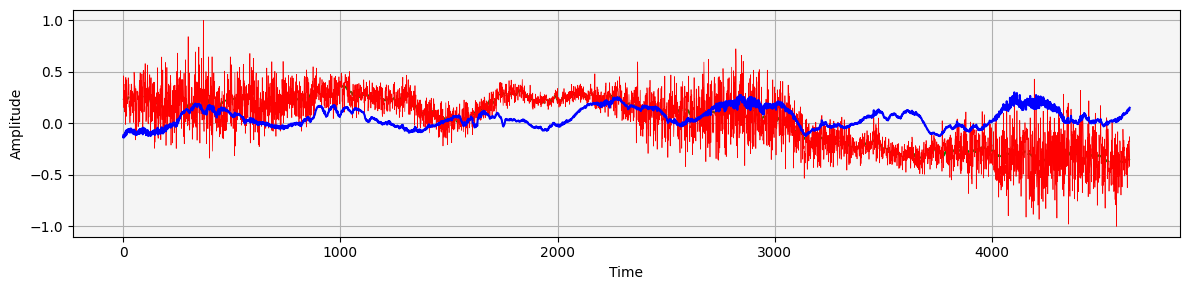

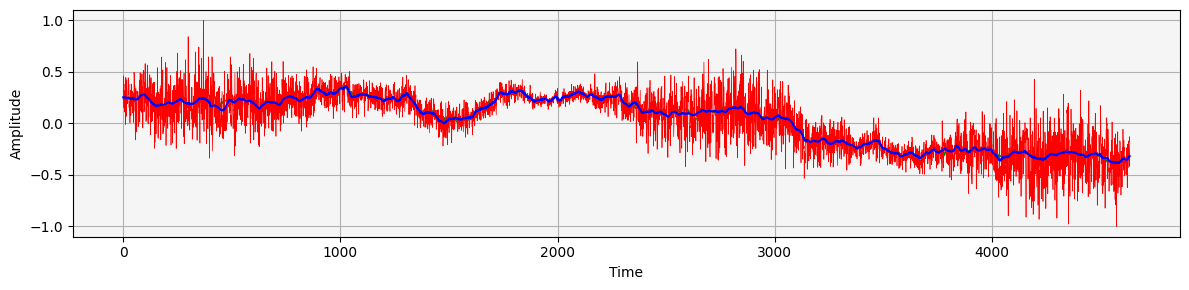

In [ ]:
def sample_test(model, noisy_data, clean_data):
    # 测试模型
    model.eval()
    with torch.no_grad():
        # test_input = noisy_signals[0:1]
        test_idx = random.randint(0, len(noisy_data))
        test_input = noisy_data[test_idx:test_idx+1]
        denoised_signal = model(test_input).squeeze().cpu().numpy()
        plot_results(clean_data[test_idx].squeeze().cpu().numpy(), noisy_data[test_idx].squeeze().cpu().numpy(), denoised_signal)

        test_ouput = None
        for j in range(0, 4634, window_step):
            test_input = noisy_data[test_idx:test_idx+1, j:j+window]
            denoised_signal = model(test_input).squeeze().cpu().numpy()
            if test_ouput is None:
                test_ouput = denoised_signal
            else:
                test_ouput[-100:] = (test_ouput[-100:] + denoised_signal[:100]) / 2
                test_ouput = np.concatenate([test_ouput, denoised_signal[100:]])
        
        plot_results(clean_data[test_idx].squeeze().cpu().numpy(), noisy_data[test_idx].squeeze().cpu().numpy(), test_ouput)

        

# 对比发现，虽然我的神经网络对于输入长度是不受限制的，但是由于训练时候是滑动窗口，依然使用滑动窗口的方式做inference是最好的。
sample_test(model=model, noisy_data=val_noisy, clean_data=val_clean)
# sample_test(model=model, noisy_data=train_noisy, clean_data=train_clean)